In [1]:
%run Latex_macros.ipynb 


<IPython.core.display.Latex object>

Macro `_latex_std_` created. To execute, type its name (without quotes).
=== Macro contents: ===
get_ipython().run_line_magic('run', 'Latex_macros.ipynb ')
 no stored variable _latex_std_


In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
         
    
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import recipe_helper
%aimport recipe_helper
rh = recipe_helper.Recipe_Helper()

# Transformation pipelines

Transformations are a key part of the Recipe for Machine Learning.

A transformation $T$ changes raw input example $\x$ into transformed example $\x' = T(\x)$.

Features may have been added, dropped, re-scaled, etc.

What is important is that our model (hypothesis $h$) computes $h(T(\x))$ rather than $h(\x)$

<img src=images/ML_process_pipeline.jpg>

We were very deliberate in first computing $T(\x)$ during training.

When predicting on a non-training example $\x$ (e.g., validation, test) we must apply the *identical* $T$
to ensure that the prediction is $h(T(x))$.
- in the most obvious case: $\x$ and $T(\x)$ have different "shapes" and thus we can't compute $h(\x)$.
    - $\x = (1, \x_1)$ versus $T(\x) = (1, \x_1, \x_1^2)$

We applied only a single transformation in our first example but, in general, there may be *sequence*  of transformations to apply.
$$T_1, T_2, \ldots T_t$$

We refer to a sequence of transformations as a pipeline.
$$T(\x) = T_t( \,T_{t-1} ( \ldots T_2(\,\, T_1(\x)\,\,) ) \,)$$

That is: the pipeline is a single transformation $T$ that is the *sequential composition* of each transformation.
- first apply $T_1$ to input $\x$ to yield $T_1(\x)$
- then apply $T_2$ to the result to yield $T_2( \; T_1(\x) \; )$
- etc.

You can
- create your own class and methods for a transformation
    - with a "fit" method to fit during training
    - with a "transform" method to apply
        - during training
        - during test


        
Alternatively, you can take advantage of `sklearn`'s built-in "pipelines"

Regardless of how you implement transformations it's important that thye satisfy some key properties.


# Key properties in implementing transformations

We'll motivate key properties of transformation code using our module for fitting the "curvy" dataset.

We will then switch to the more refined methods of `sklearn`.

You *don't have to* use `sklearn`'s method, but you *do* have to satisfy key properties.

## Consistent application across train, validation and test

The transformation pipeline $T$ should work the same way for any example.

By creating a single method that works for *any* example we ensure consistency.


## No cheating, even in transformations !

The transformations in pipeline $T$ may have their own parameters.

**These parameters are fit on the **training** data and nothing else !

`X_train, X_test, y_train, y_test = split(X,y)` 

`T.fit(X_train)`

but used to **transform all data**

- `X_train-trans = T.transform(X_train)`

- `X_validation_trans = T.transform(X__validation)`

- `X_test_trans = T.transform(X_test)`

Is this different from first fitting the *entire* dataset $\X$ and then splitting ?

`T.fit(X)`

`X_trans = T.transform(X)`

`X_train, X_test, y_train, y_test = split(X,y)` 

Most definitely !

The `fit` method, when applied to the entire set $\X$ has **cheated** by looking at what will become $\X_\text{test}$

For example
- a missing data imputation transformation should use
$$\text{mean}(\X_{\text{train}})$$
not 
$$\text{mean}(\X)$$

## No cheating in cross-validation !

Cross-validation provides a subtle opportunity to "cheat"

$k$-fold cross validation creates $k$ different (train, validation) set splits.

Let $\X'_{(j)}, \X''_{(j)}$ denote the partition of $\X$ into the train/validation set for split $j$.
- $\X'_{(j)}$ is used to train one model instance, which is evaluated on hold-out data $\X''_{(j)}$
- $\X''_{(j)}$ serves the role of "test" set for the $j^{th}$  split
- So pipeline $T$ should be fit on  only $\X'_{(j)}$ rather than the entire $\X$
    - it would be cheating to see $\X''_{(j)}$

# Pipelines in sklearn

`sklearn` has created a generic architecture to simplify this for you.

We'll give a quick overview of how `sklearn` facilitates transformations.

Let's create a pipeline with the following stages
- create polynomial features of order up to and including 2
- linear regression

What we have done is used Pipelines to create a new model
$$
h'(\x) = h(\, T(\x) \, )
$$

This "model" combines the transformation and fitting steps.

We can use $h'$ just as we used $h$
- for example in cross validation: `h'.cross_val_score( .. )`

This is a simple implementation that avoids "cheating" by wrapping *all steps* into a single function.

Notice how we have included the Linear Regression step as part of the pipeline.

This means that the pipeline can run all the steps up to and including fitting of the model
- data preparation
- training

That is: we can treat the pipeline as a self-contained model that performs its own prerequisites.

In addition to being a convenience, a pipeline ending in a model
- **avoids the potential to cheat in cross-validation**
- cross-validation performs `transform` and `predict` for each fold as hold-out
    - passing in the non-holdout as train
    - so the `transform` never sees the holdout data for the fold !

In [4]:
# I will give you the data via a function (so I can easily alter the data in subsequent examples)
v1, a1 = 1, .005

X_lin, y_lin = rh.gen_data(num=50, v=v1, a=a1)

v2, a2 = v1, a1*2
X_curve, y_curve = rh.gen_data(num=50, v=v2, a=a2)


X_train, X_test, y_train, y_test = rh.split(X_curve,y_curve)


In [5]:
from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing as pre_proc

# Create the Pipeline
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(pre_proc.PolynomialFeatures(2),
                           linear_model.LinearRegression())

# Fit the model, running the data transformation first
poly_model.fit(X_train.reshape(-1,1), y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

A pipeline successively applies tranformations, with the result of transformation $(i-1)$ fed as input to transformation $i$.

Let's look "inside" the pipeline at the stages, and apply them manually.

In [6]:
# Examine the "stages" of the pipeline
print("Input shape: {shp}".format(shp=X_test.reshape(-1,1).shape)  )

# First stage: Create First and Second Order polynomial features
(label_0, model_0) = poly_model.steps[0]
transf_0 = model_0.transform(X_test.reshape(-1,1))
print("{lab:s} returns shape: {shp}".format(lab=label_0, shp=transf_0.shape) )

# Second stage: Linear Regression
(label_1, model_1) = poly_model.steps[1]
transf_1 = model_1.predict( transf_0 )
print("{lab:s} returns shape: {shp}".format(lab=label_1, shp=transf_1.shape) )


Input shape: (10, 1)
polynomialfeatures returns shape: (10, 3)
linearregression returns shape: (10, 1)


In [7]:
# Prediction based on test set
y_pred = poly_model.predict(X_test.reshape(-1,1))

# In and out of sample scores
print("Score (train): ", poly_model.score(X_train.reshape(-1,1), y_train))
print("Score (test): ",  poly_model.score(X_test.reshape(-1,1),  y_test))

Score (train):  1.0
Score (test):  1.0


R-squared score (test): 1.00


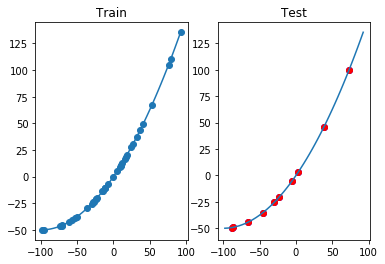

In [8]:
# Plot the results
# Create a figure
fig = plt.figure()

# Create a histogram for X.  The figure will be 1 row by 2 columns and the plot for X will be in column 1
ax = fig.add_subplot(121)
_= ax.scatter(X_train,y_train)

xfit = np.linspace( X_train[:,0].min(), X_train[:,0].max()).reshape(-1,1)
yfit = poly_model.predict(xfit)
_= ax.plot(xfit, yfit);
_= ax.set_title("Train")

ax = fig.add_subplot(122);
_ = ax.scatter(X_test, y_test, color="blue")
_ = ax.scatter(X_test, y_pred, color="red")

_ = ax.plot(xfit, yfit)
_= ax.set_title("Test")


print("R-squared score (test): {:.2f}".format(r2_score(y_test, y_pred)) )

[Here's](external/PythonDataScienceHandbook/notebooks/05.04-Feature-Engineering.ipynb#Feature-Pipelines) a slightly longer pipeline from VanderPlas.


- `Imputer` to deal with misssing values
- `PolynomialFeatures(degree=2)`
- `LinearRegression()`

## Advanced Pipelines: FeatureUnion

What if some transformations are applicable only to certain features, for example, based on feature type
- numeric transformations for numeric features
- categorical transformations for categorical features

`sklearn` facilitates this by
- Allowing you to create "filters" that restrict features to a subset
- Applying one pipeline per subset
- Creating a union of transformed features at the end


The following is a preview of the next lecture, where we will learn about non-numeric (categorical) features.

For now: just know that you can't apply numeric operations to categorical data.

Consider a dataset that contains both numeric and categorical features
- Imputation of missing data handled differently
    - Numeric: median
    - Categorical: most frequent

In addition, the categorical features will need to be encoded as numbers

- We create a custom transformer `DataFrameSelector` to "filter" (restrict) features
    - Stage "select_numeric" filters to numeric features
    - Stage "elect_cat" filters to categorical features
    
- We create one pipeline for each of the Numeric and Categorical features

- We "union" the disjoint features produced by the two pipelines into the final set of transformed features

# Recap

We emphasized the importance of performing transformations and doing so consistently.

`sklearn` has a nice framework.

Even if you choose to perform your own transformations, the ideas it implements are worth considering.

In [9]:
print("Done !")

Done !
